# Potato Disease classification

In [2]:
# We import the required libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
Image_size = 256
Batch_size = 32
CHANNELS=3
EPOCHS=50

### Import and prepare the Data

In [4]:
# Import the image datasets as classes
# The images were obtained from Kaggle website
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)

Found 2152 files belonging to 3 classes.


In [5]:
# dataset classes in the directory
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

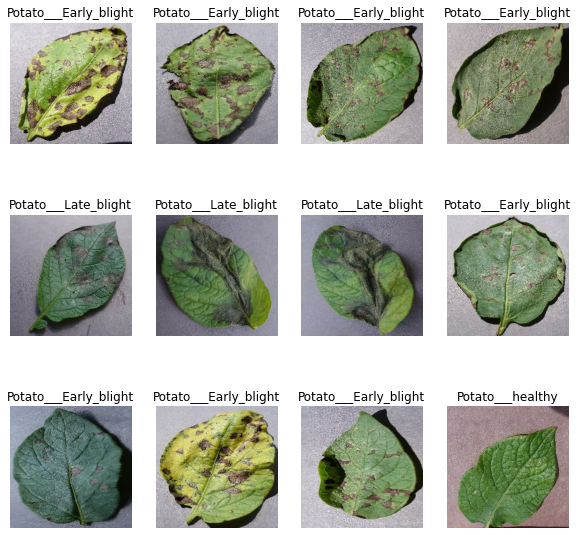

In [7]:
# We visualize the sample data for understanding
plt.figure(figsize=(10,10))
# we visualize the data
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
# A function which splits the data into train, test, validation test
#data is shuffled and 80% train split and 10% each with test and validation split
# length of dataset = 68
def get_datasets_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split* ds_size)
    val_size = int(val_split* ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    
    return train_ds, test_ds, val_ds

In [9]:
train_ds, test_ds, val_ds = get_datasets_partitions_tf(dataset)

### Cache, Shuffle and Prefetch the dataset

In [10]:
#Cache, Shuffle, Prefetch the data
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

### Data Augmentation

In [11]:
# Here data Augmentation Needed Data rescaling, Data resizing is imp (so in future aspects the data will be sorted)
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
# Data Augmentation to make our model robust
# watch vedio TensorFlow data augmentation codebasics

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),

])

In [13]:
# Apply data augmentation on training set:
train_ds = train_ds.map(
    lambda x,y : (data_augmentation(x,training = True), y)
).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model Architecture

In [14]:
input_shape = (Batch_size, Image_size, Image_size, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

## Compiling the model

In [16]:
model.compile(
    optimizer ='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    batch_size= Batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 122s 2s/step - loss: 0.8989 - accuracy: 0.5006 - val_loss: 0.9361 - val_accuracy: 0.4688
Epoch 2/50
54/54 [==============================] - 112s 2s/step - loss: 0.6423 - accuracy: 0.6950 - val_loss: 0.3362 - val_accuracy: 0.8802
Epoch 3/50
54/54 [==============================] - 110s 2s/step - loss: 0.4609 - accuracy: 0.8090 - val_loss: 0.1693 - val_accuracy: 0.9479
Epoch 4/50
54/54 [==============================] - 107s 2s/step - loss: 0.2585 - accuracy: 0.9039 - val_loss: 0.4263 - val_accuracy: 0.8073
Epoch 5/50
54/54 [==============================] - 109s 2s/step - loss: 0.1391 - accuracy: 0.9520 - val_loss: 0.0660 - val_accuracy: 0.9844
Epoch 6/50
54/54 [==============================] - 106s 2s/step - loss: 0.1380 - accuracy: 0.9497 - val_loss: 0.1545 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 109s 2s/step - loss: 0.1085 - accuracy: 0.9635 - val_loss: 0.2123 - val_accuracy: 0.9219
Epoch 8/50
54

In [18]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 313ms/step - loss: 0.0014 - accuracy: 1.0000


In [19]:
scores

[0.0014022639952600002, 1.0]

## Plotting the Accuracy and Loss Curves

In [20]:
history

In [21]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
# Accuracy, validation_accuracy and loss and validation_loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

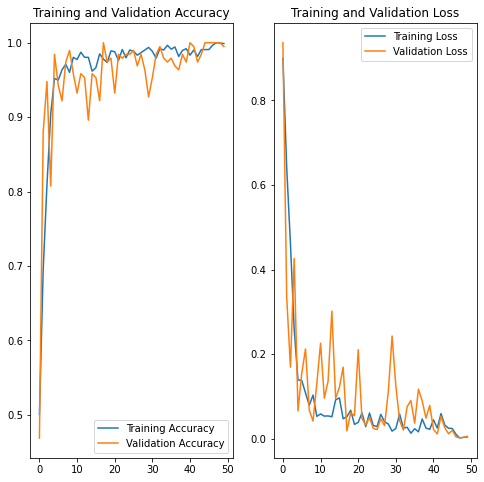

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
# The x axis values are epochs, which were upto 50.

first image to predict
first image's actual label: Potato___Late_blight
first image of predicted label: Potato___Late_blight


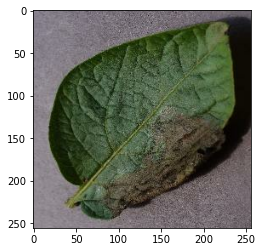

In [27]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])
    
    batch_predict = model.predict(image_batch)
    print("first image of predicted label:", class_names[np.argmax(batch_predict[0])])

In [28]:
# we write a function which predicts predicted class and confidence in the prediction
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # we create a batch here
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

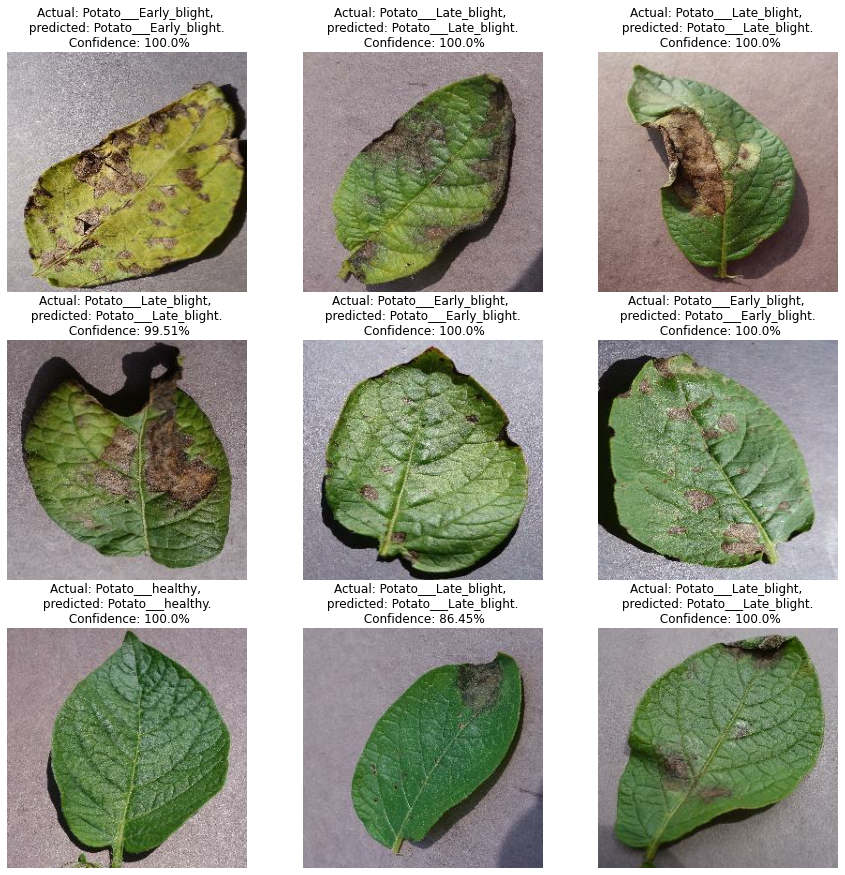

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis("off")